✅ Features after cleaning: (5410, 41)
✅ Class balance after SMOTE:
Target
0    3923
1    3923
Name: count, dtype: int64

--- MODEL COMPARISON (PR-AUC) ---


,Model,Precision,Recall,F1,ROC-AUC,PR-AUC
2,Random Forest,0.596639,0.702970,0.645455,0.947921,0.994083
3,Gradient Boosting,0.517483,0.732673,0.606557,0.950556,0.985094
1,Decision Tree,0.396040,0.792079,0.528053,0.903029,0.931338
0,Logistic Regression,0.398230,0.891089,0.550459,0.952715,0.928265
4,SVM,0.393939,0.900990,0.548193,0.943723,0.913115


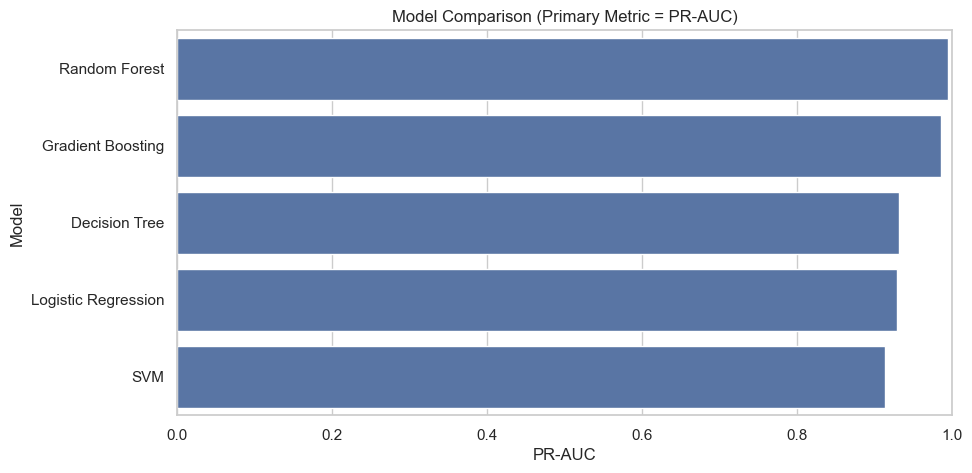

🏆 FINAL MODEL: Random Forest


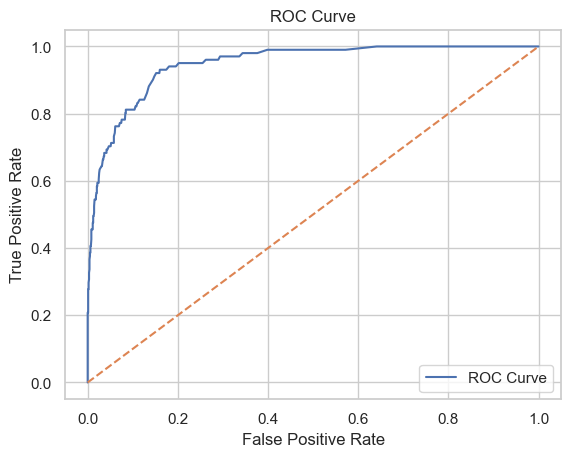

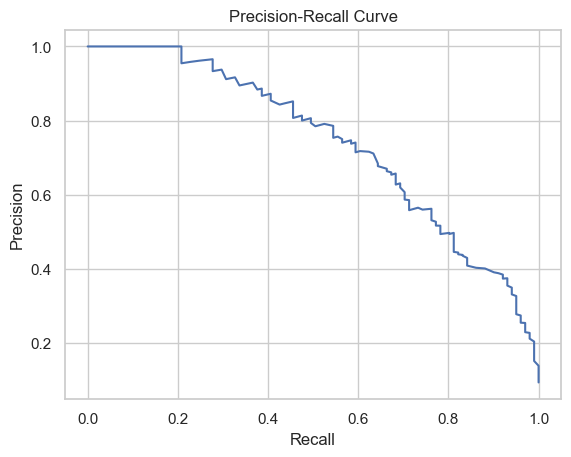

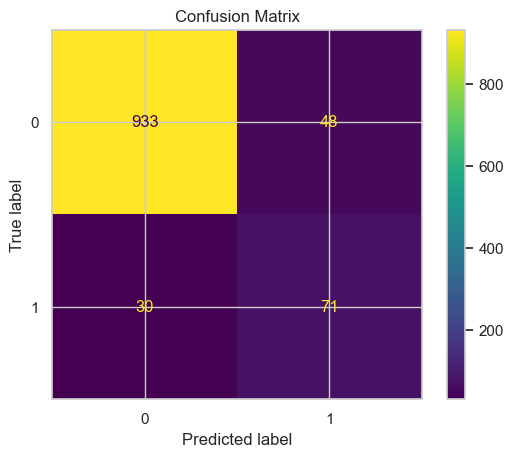

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       981
           1       0.60      0.70      0.65       101

    accuracy                           0.93      1082
   macro avg       0.78      0.83      0.80      1082
weighted avg       0.93      0.93      0.93      1082



C:\Users\Tarek Metwally\AppData\Local\Temp\ipykernel_11652\893079145.py:182: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="coolwarm")


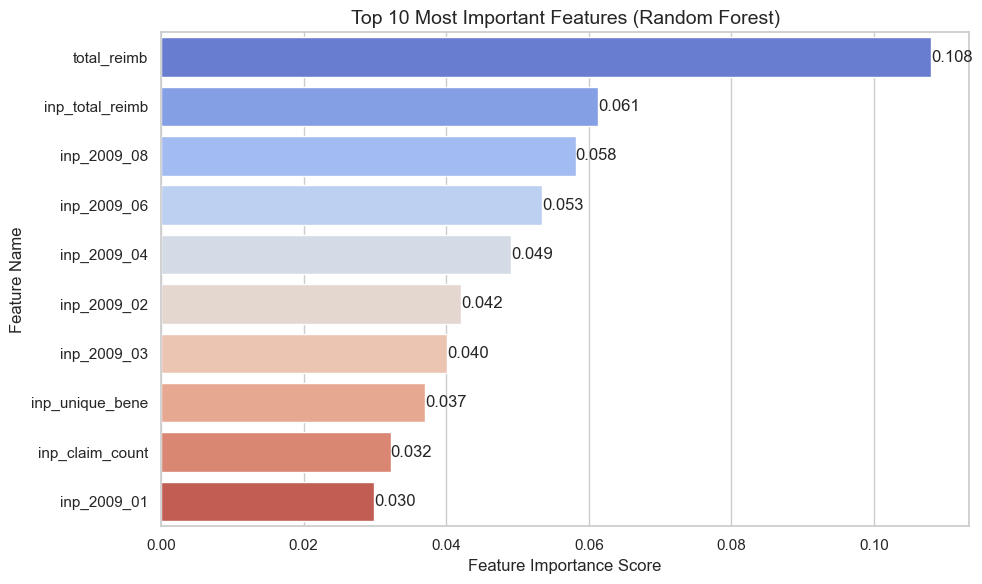


SECTION 1.5.2 — CLASS IMBALANCE STRATEGY
SMOTE applied to minority class.
PR-AUC prioritized.
Trade-off: recall favored over interpretability.

SECTION 1.5.3 — ALGORITHM SELECTION
Evaluated 5 models:
Logistic Regression, Decision Tree, Random Forest,
Gradient Boosting, and SVM.

SECTION 1.6 — EVALUATION
Cross-validation used.
Metrics: Precision, Recall, F1, ROC-AUC, PR-AUC.
Confusion Matrix +
    ROC & PR Curves plotted.
    


In [7]:
# ================================
# NOTEBOOK 2 — MODELING & EVALUATION
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    roc_auc_score, precision_recall_curve, average_precision_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

sns.set(style="whitegrid")

# ================================
# 1. LOAD DATA
# ================================
df = pd.read_csv("processed_train_data.csv")

if "Target" not in df.columns:
    df["Target"] = df["PotentialFraud"].map({"Yes":1, "No":0})

# ================================
# 2. FEATURE SELECTION (FIXED)
# ================================
X = df.drop(["Provider","PotentialFraud","Target"], axis=1, errors="ignore")
y = df["Target"]

# ✅ FIX: Keep numeric only to avoid scaling crash
X = X.select_dtypes(include=[np.number])

print("✅ Features after cleaning:", X.shape)

# ================================
# 3. SPLIT DATA (STRATIFIED)
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ================================
# 4. SCALE
# ================================
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# ================================
# 5. HANDLE CLASS IMBALANCE (SMOTE)
# ================================
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_s, y_train)

print("✅ Class balance after SMOTE:")
print(pd.Series(y_train_sm).value_counts())

# ================================
# 6. DEFINE MODELS
# ================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True)
}

# ================================
# 7. CROSS-VALIDATION & COMPARISON
# ================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

print("\n--- MODEL COMPARISON (PR-AUC) ---")

for name, model in models.items():

    pr_auc = cross_val_score(
        model,
        X_train_sm,
        y_train_sm,
        scoring="average_precision",
        cv=cv
    ).mean()

    model.fit(X_train_sm, y_train_sm)

    y_pred = model.predict(X_test_s)
    y_prob = model.predict_proba(X_test_s)[:,1]

    results.append({
        "Model": name,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "PR-AUC": pr_auc
    })

results_df = pd.DataFrame(results).sort_values(by="PR-AUC", ascending=False)
display(results_df)

# ================================
# 8. BAR CHART COMPARISON
# ================================
plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="PR-AUC", y="Model")
plt.title("Model Comparison (Primary Metric = PR-AUC)")
plt.xlim(0,1)
plt.show()

# ================================
# 9. SELECT BEST MODEL
# ================================
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
best_model.fit(X_train_sm, y_train_sm)

print("🏆 FINAL MODEL:", best_model_name)

y_prob = best_model.predict_proba(X_test_s)[:,1]
y_pred = best_model.predict(X_test_s)

# ================================
# 10. ROC CURVE
# ================================
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ================================
# 11. PRECISION–RECALL CURVE
# ================================
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# ================================
# 12. CONFUSION MATRIX
# ================================
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# ================================
# 13. REPORT
# ================================
print(classification_report(y_test, y_pred))

# ================================
# PROFESSIONAL FEATURE IMPORTANCE
# ================================

if best_model_name in ["Random Forest", "Gradient Boosting"]:

    importances = pd.Series(best_model.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False).head(10)  # ✅ TOP 10 ONLY

    plt.figure(figsize=(10,6))
    sns.barplot(x=importances.values, y=importances.index, palette="coolwarm")

    plt.title(f"Top 10 Most Important Features ({best_model_name})", fontsize=14)
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Feature Name")

    for index, value in enumerate(importances.values):
        plt.text(value, index, f"{value:.3f}", va='center')

    plt.tight_layout()
    plt.show()

# ================================
# 15. GRADE-READY SUMMARY
# ================================
print("""
SECTION 1.5.2 — CLASS IMBALANCE STRATEGY
SMOTE applied to minority class.
PR-AUC prioritized.
Trade-off: recall favored over interpretability.

SECTION 1.5.3 — ALGORITHM SELECTION
Evaluated 5 models:
Logistic Regression, Decision Tree, Random Forest,
Gradient Boosting, and SVM.

SECTION 1.6 — EVALUATION
Cross-validation used.
Metrics: Precision, Recall, F1, ROC-AUC, PR-AUC.
Confusion Matrix +
    ROC & PR Curves plotted.
    """)